## Anomaly Detection with Isolation Forest (IF)

Isolation Forest 알고리즘은 2008년 Nanjing University의 Zhou Zhihua 교수가 처음 제안하였다.<br>
논문은 http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf 에서 다운로드할 수 있다.<br>
이 anomaly detection 방법론은 시간 복잡도가 linear하고 적은 메모리 요구 사항이 필요하고 고차원과 대규모 데이터셋에 대해서도 잘 동작하여, 여러 산업 현장에서 효과적인 것으로 밝혀졌다. 

### Main Idea

이상치(Anomalies)는 개수가 적고 다른 데이터와 달라(few and different) 공간을 랜덤하게 분할했을 때 더 쉽게 정상 데이터와 격리 시킬 수 있다.

원 논문에 그림에서 이 이론을 쉽게 표현하였다.

![title](IF0.png)

2차원 공간을 수직선이나 수평선으로 랜덤하게 분할할 때 이상 포인트 x_o은 정상 포인트 x_i에 비해 더 쉽게 격리 될 수 있다. 다시 말해 적은 분할 횟수로 이상 포인트들을 격리시킬 수 있다. 공간을 랜덤한 초평면(hyperplane)을 사용해 분할시켜 고차원 공간에서도 같은 방식으로 동작한다.

recursive partitioning 과정은 바이너리 트리로 표현할 수 있다. 루트 노드에서 현재 노드까지의 path 길이는 이 노드를 격리 시키는 데 필요한 파티션 횟수이다. 

![title](IF1.png)

Isolation Forest는 이러한 랜덤 트리로 구성하고, 평균 path 길이를 아웃라이어 정도(outlierness)를 평가하는 척도로 사용한다.

아래 그림에서 볼수 있듯이 랜덤 트리가 자랄수록, x_o와 x_i의 평균 path 길이상수 값으로 수렴하는 것을 확인할 수 있다. 아웃라이어 x_o는 따라서, 이 알고리즘에 의해 xi와 확실히 구별할 수 있다.

Sub-sampling은 트리를 구성할 때 중요한 개념이다. Isolation Forest에서 트리를 만드는 모든 시점마다 전체 트레이닝 셋에서 서브 샘플링한 일부만을 사용한다.

RandomForest와 마찬가지로 Sub-sampling을 통한 다양성(Diversity)를 높힘으로써 모델의 성능을 극대화 하기 위해서 이다.

![title](IF2.png)

## 구현

### 라이브러리 설치

먼저, 여기서 sklearn.ensemble에 있는 Isolation 패키지를 설치한다. 그 다음 직접 생성한 간단한 데이터셋을 통해 어떻게 동작하는 지 확인한다. 

먼저 scikit-learn 패키지를 pip 이나 conda를 사용해 설치한다.<br>
 \$ pip install -U scikit-learn
<br>
 \$ conda install scikit-learn

scikit-learn 버전이 0.18 이상인지 확인한다. 낮은 경우 IsolationForest가 없어 다음 명령어로 업데이트할 수 있다.<br> \$ conda update scikit-learn

먼저 필요한 라이브러리들을 불러온다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

#### 전시간에 저장했던 Multi modal 데이터를 불러온다

In [2]:
import pickle
with open('./data/Multi_Modal.pickle', 'rb') as f:
    data = pickle.load(f)    

In [3]:
data.keys()

dict_keys(['TR_Input', 'VL_Input', 'TE_Input', 'VL_Output', 'TE_Output'])

In [4]:
TR_Input = data['TR_Input']
VL_Input = data['VL_Input']
TE_Input = data['TE_Input']
VL_Output = data['VL_Output']
TE_Output = data['TE_Output']

Isolation Forest 모델을 정의하고 파라미터를 지정한다.

In [5]:
iforest = IsolationForest(max_samples=200, n_estimators=150, random_state=10)
iforest.fit(TR_Input)

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples=200, n_estimators=150, n_jobs=None,
        random_state=10, verbose=0)

각 그리드 포인트 들에 대해 Outlier score를 계산한다.

In [6]:
# generate grid points, which will later be used to calculate anomaly score
x_grid = np.linspace(1, 12, 100)
y_grid = np.linspace(1, 12, 100)
x, y = np.meshgrid(x_grid, y_grid)

# calculate anomaly score for each grid points
anomaly_score = iforest.decision_function(np.c_[x.ravel(), y.ravel()])
anomaly_score = anomaly_score.reshape(100, 100)


### Threshold를 정하기 전에 먼저 Anomaly score를 한번 시각화 해보자

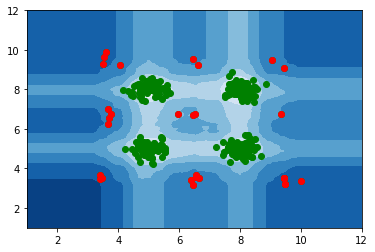

In [7]:
plt.contourf(x, y, anomaly_score, cmap=plt.cm.Blues_r)
plt.scatter(VL_Input[:, 0], VL_Input[:, 1], c="green")
plt.scatter(VL_Input[np.where(VL_Output==1), 0], VL_Input[np.where(VL_Output==1), 1], c="red")
plt.show()

In [8]:
anomaly_score_Valid = iforest.decision_function(VL_Input)

In [9]:
# Validation set을 통해 가장 좋은 epsilon(임계치) 탐색
def selectThresholdByIF(NL,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(NL) - min(NL)) / 1000;
    epsilons = np.arange(min(NL)+0.001,max(NL),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (NL < epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon    
    return best_f1, best_epsilon

In [10]:
fscore, threshold = selectThresholdByIF(anomaly_score_Valid,VL_Output)
print(fscore, threshold)

1.0 -0.07649231298871861


#### 이제 Test dataset에 적용해 보자

In [11]:
anomaly_score_Test = iforest.decision_function(TE_Input)
outliers = np.asarray(np.where(anomaly_score_Test <= threshold))

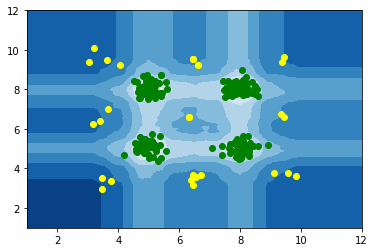

In [12]:
plt.contourf(x, y, anomaly_score, cmap=plt.cm.Blues_r)
plt.scatter(TE_Input[:, 0], TE_Input[:, 1], c="green")
plt.scatter(TE_Input[np.where(TE_Output==1), 0], TE_Input[np.where(TE_Output==1), 1], c="yellow")
plt.show()

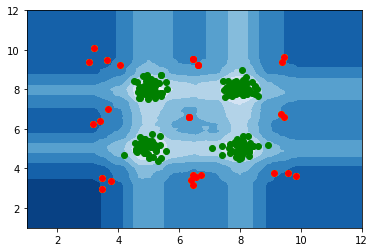

In [14]:
plt.contourf(x, y, anomaly_score, cmap=plt.cm.Blues_r)
plt.scatter(TE_Input[:, 0], TE_Input[:, 1], c="green")
plt.scatter(TE_Input[np.where(TE_Output==1), 0], TE_Input[np.where(TE_Output==1), 1], c="yellow")
plt.scatter(TE_Input[outliers, 0], TE_Input[outliers, 1], c="red")
plt.show()